## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [4]:
strings = list(df.dtypes[df.dtypes == 'object'].index)
for col in strings:
    df[col] = df[col].str.lower().str.replace(' ', '_')
    
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
                                   
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

y_train

array([4.7095302 , 4.26267988, 6.13339804, ..., 3.93182563, 5.52545294,
       5.39362755])

Now, use `DictVectorizer` to turn train and validation into matrices:

In [5]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

df_train.head()

,neighbourhood_group,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,queens,40.76434,-73.92132,entire_home/apt,4,30,0.32,1,363
1,brooklyn,40.73442,-73.95854,private_room,5,2,0.16,1,0
2,brooklyn,40.66359,-73.99487,entire_home/apt,1,33,2.75,5,113
3,brooklyn,40.63766,-74.02626,private_room,3,1,0.12,2,362
4,brooklyn,40.65118,-74.00842,private_room,2,0,0.00,2,365


## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [6]:
train_dicts = df_train.fillna(0).to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [7]:
from sklearn.metrics import mean_squared_error

val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_pred = dt.predict(X_val)

score = np.sqrt(mean_squared_error(y_val, y_pred))
print(score)


y_pred2 = dt.predict(X_train)
score = np.sqrt(mean_squared_error(y_train, y_pred2))
print(score)

0.5488190627763704
0.5496412649960563


In [8]:
from sklearn.tree import export_text
print(export_text(dt, feature_names=dv.get_feature_names()))
##room_type - Q1

|--- room_type=entire_home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=entire_home/apt >  0.50
|   |--- value: [5.15]



/home/aljekso/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Which feature is used for splitting the data?

* `room_type`!
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [9]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=10, random_state=1,n_jobs=-1 )
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
score = np.sqrt(mean_squared_error(y_val, y_pred))
print(score)

0.4598535778342608


What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459!
* 0.659

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

0.4598535778342608
0.44783122647617707
0.44512003484498197
0.44322540476599925
0.4422309033499618
0.4415347874157756
0.4408665092520829
0.44076264110112295
0.4402436823066316
0.439782812295518
0.4393283276631756
0.439140100985395
0.4392600896545383
0.4391068172724505
0.4390987893907921
0.43891283738859316
0.43886569128153563
0.4390536136991923
0.4389458407581751


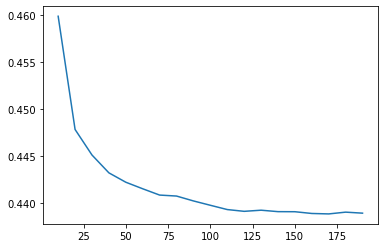

In [70]:
scores = []

for n in range(10, 200, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1,n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    print(n)
    print(score)
    scores.append((n, score))
    
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'score'])
plt.plot(df_scores.n_estimators, df_scores.score)

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120 !

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [74]:
scores = []
for d in [10, 15, 20, 25]:
    for n in range(10, 200, 10):
        rf = RandomForestRegressor(n_estimators=n, random_state=1, max_depth=d ,n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))
        print('n %d' % d)
        print('d %d' % n)
        print('score %5.4f' % score)
        scores.append((d, n, score))
    


n 10
d 10
score 0.4456
n 10
d 20
score 0.4420
n 10
d 30
score 0.4414
n 10
d 40
score 0.4415
n 10
d 50
score 0.4411
n 10
d 60
score 0.4411
n 10
d 70
score 0.4408
n 10
d 80
score 0.4406
n 10
d 90
score 0.4404
n 10
d 100
score 0.4401
n 10
d 110
score 0.4401
n 10
d 120
score 0.4398
n 10
d 130
score 0.4399
n 10
d 140
score 0.4399
n 10
d 150
score 0.4397
n 10
d 160
score 0.4396
n 10
d 170
score 0.4396
n 10
d 180
score 0.4397
n 10
d 190
score 0.4397
n 15
d 10
score 0.4498
n 15
d 20
score 0.4408
n 15
d 30
score 0.4394
n 15
d 40
score 0.4388
n 15
d 50
score 0.4381
n 15
d 60
score 0.4378
n 15
d 70
score 0.4374
n 15
d 80
score 0.4373
n 15
d 90
score 0.4369
n 15
d 100
score 0.4365
n 15
d 110
score 0.4363
n 15
d 120
score 0.4362
n 15
d 130
score 0.4363
n 15
d 140
score 0.4362
n 15
d 150
score 0.4363
n 15
d 160
score 0.4361
n 15
d 170
score 0.4360
n 15
d 180
score 0.4361
n 15
d 190
score 0.4361
n 20
d 10
score 0.4598
n 20
d 20
score 0.4468
n 20
d 30
score 0.4441
n 20
d 40
score 0.4424
n 20
d 50
scor

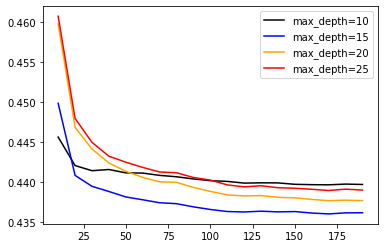

In [77]:
columns = ['min_samples_leaf', 'n_estimators', 'score']
df_scores = pd.DataFrame(scores, columns=columns)

colors = ['black', 'blue', 'orange', 'red']
values = [10, 15, 20, 25]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.score,
             color=col,
             label='max_depth=%d' % s)

plt.legend()

What's the best `max_depth`:

* 10
* 15!
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [89]:
rf = RandomForestRegressor(n_estimators=10,random_state=1,n_jobs=-1,max_depth=20)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
score = np.sqrt(mean_squared_error(y_val, y_pred))
print(score)
print(dv.get_feature_names())
print(np.round(rf.feature_importances_, 3))

0.45976438614210824
['availability_365', 'calculated_host_listings_count', 'latitude', 'longitude', 'minimum_nights', 'neighbourhood_group=bronx', 'neighbourhood_group=brooklyn', 'neighbourhood_group=manhattan', 'neighbourhood_group=queens', 'neighbourhood_group=staten_island', 'number_of_reviews', 'reviews_per_month', 'room_type=entire_home/apt', 'room_type=private_room', 'room_type=shared_room']
[0.077 0.03  0.152 0.153 0.053 0.    0.001 0.034 0.001 0.    0.043 0.055
 0.392 0.005 0.004]


/home/aljekso/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	!
* `longitude`
* `latitude`

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [90]:
!pip install xgboost

     |████████████████████████████████| 173.5 MB 108 kB/s eta 0:00:012  |▎                               | 1.2 MB 2.2 MB/s eta 0:01:18     |▋                               | 3.4 MB 2.2 MB/s eta 0:01:17     |▊                               | 3.7 MB 2.2 MB/s eta 0:01:17     |▉                               | 4.6 MB 2.2 MB/s eta 0:01:17     |█▏                              | 6.6 MB 2.2 MB/s eta 0:01:15     |█▋                              | 8.4 MB 2.2 MB/s eta 0:01:14     |██▉                             | 15.2 MB 11.8 MB/s eta 0:00:14     |███                             | 15.9 MB 11.8 MB/s eta 0:00:14     |███                             | 16.5 MB 11.8 MB/s eta 0:00:14     |███▏                            | 17.2 MB 11.8 MB/s eta 0:00:14     |███▋                            | 19.8 MB 2.1 MB/s eta 0:01:15     |███▉                            | 20.7 MB 2.1 MB/s eta 0:01:14     |█████▏                          | 28.0 MB 2.0 MB/s eta 0:01:13     |█████▏                          | 28.3 MB 2.0

In [20]:
#%%capture output
import xgboost as xgb
watchlist = [(dtrain, 'train'), (dval, 'val')]

features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)
y_pred = model.predict(dval)

#score = np.sqrt(mean_squared_error(y_val, y_pred))
#print(score)

/home/aljekso/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[0]	train-rmse:3.02752	val-rmse:3.02415
[1]	train-rmse:2.14667	val-rmse:2.14390
[2]	train-rmse:1.53878	val-rmse:1.53721
[3]	train-rmse:1.12557	val-rmse:1.12523
[4]	train-rmse:0.85100	val-rmse:0.85174
[5]	train-rmse:0.67490	val-rmse:0.67752
[6]	train-rmse:0.56687	val-rmse:0.57148
[7]	train-rmse:0.50448	val-rmse:0.51139
[8]	train-rmse:0.46913	val-rmse:0.47777
[9]	train-rmse:0.45009	val-rmse:0.45965
[10]	train-rmse:0.43912	val-rmse:0.44981
[11]	train-rmse:0.43327	val-rmse:0.44475
[12]	train-rmse:0.42936	val-rmse:0.44210
[13]	train-rmse:0.42668	val-rmse:0.44038
[14]	train-rmse:0.42463	val-rmse:0.43943
[15]	train-rmse:0.42259	val-rmse:0.43827
[16]	train-rmse:0.42113	val-rmse:0.43772
[17]	train-rmse:0.42074	val-rmse:0.43787
[18]	train-rmse:0.41896	val-rmse:0.43744
[19]	train-rmse:0.41812	val-rmse:0.43726
[20]	train-rmse:0.41716	val-rmse:0.43691
[21]	train-rmse:0.41499	val-rmse:0.43645
[22]	train-rmse:0.41437	val-rmse:0.43611
[23]	train-rmse:0.41403	val-rmse:0.43614
[24]	train-rmse:0.41391	va

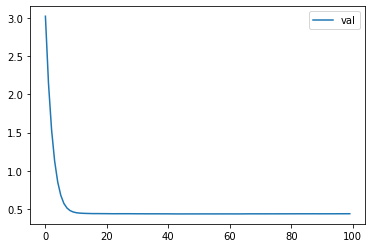

In [22]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

df_score = parse_xgb_output(output)
plt.plot(df_score.num_iter, df_score.val_rmse, label='val')
plt.legend()

Now change `eta` first to `0.1` and then to `0.01`

In [23]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)
y_pred = model.predict(dval)

[0]	train-rmse:3.87217	val-rmse:3.86889
[1]	train-rmse:3.49150	val-rmse:3.48840
[2]	train-rmse:3.14949	val-rmse:3.14635
[3]	train-rmse:2.84232	val-rmse:2.83951
[4]	train-rmse:2.56650	val-rmse:2.56412
[5]	train-rmse:2.31905	val-rmse:2.31692
[6]	train-rmse:2.09714	val-rmse:2.09526
[7]	train-rmse:1.89834	val-rmse:1.89663
[8]	train-rmse:1.72033	val-rmse:1.71878
[9]	train-rmse:1.56120	val-rmse:1.55976
[10]	train-rmse:1.41910	val-rmse:1.41786
[11]	train-rmse:1.29248	val-rmse:1.29149
[12]	train-rmse:1.17977	val-rmse:1.17907
[13]	train-rmse:1.07974	val-rmse:1.07936
[14]	train-rmse:0.99113	val-rmse:0.99118
[15]	train-rmse:0.91299	val-rmse:0.91348
[16]	train-rmse:0.84421	val-rmse:0.84524
[17]	train-rmse:0.78390	val-rmse:0.78525
[18]	train-rmse:0.73111	val-rmse:0.73308
[19]	train-rmse:0.68507	val-rmse:0.68776
[20]	train-rmse:0.64528	val-rmse:0.64883
[21]	train-rmse:0.61109	val-rmse:0.61518
[22]	train-rmse:0.58175	val-rmse:0.58648
[23]	train-rmse:0.55655	val-rmse:0.56186
[24]	train-rmse:0.53529	va

In [24]:
xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)
y_pred = model.predict(dval)

[0]	train-rmse:4.25336	val-rmse:4.25010
[1]	train-rmse:4.21141	val-rmse:4.20815
[2]	train-rmse:4.16988	val-rmse:4.16661
[3]	train-rmse:4.12877	val-rmse:4.12551
[4]	train-rmse:4.08807	val-rmse:4.08481
[5]	train-rmse:4.04779	val-rmse:4.04454
[6]	train-rmse:4.00792	val-rmse:4.00467
[7]	train-rmse:3.96845	val-rmse:3.96521
[8]	train-rmse:3.92937	val-rmse:3.92615
[9]	train-rmse:3.89070	val-rmse:3.88749
[10]	train-rmse:3.85242	val-rmse:3.84921
[11]	train-rmse:3.81452	val-rmse:3.81133
[12]	train-rmse:3.77701	val-rmse:3.77382
[13]	train-rmse:3.73988	val-rmse:3.73671
[14]	train-rmse:3.70313	val-rmse:3.69996
[15]	train-rmse:3.66674	val-rmse:3.66359
[16]	train-rmse:3.63073	val-rmse:3.62759
[17]	train-rmse:3.59508	val-rmse:3.59195
[18]	train-rmse:3.55979	val-rmse:3.55666
[19]	train-rmse:3.52487	val-rmse:3.52175
[20]	train-rmse:3.49030	val-rmse:3.48719
[21]	train-rmse:3.45608	val-rmse:3.45298
[22]	train-rmse:3.42220	val-rmse:3.41910
[23]	train-rmse:3.38867	val-rmse:3.38559
[24]	train-rmse:3.35548	va

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1!
* 0.01

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

